In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd '/content/drive/MyDrive/LSTM'
!ls

/content/drive/MyDrive/LSTM
LSTM.ipynb  ner_datasetreference.csv


### 0. Prepare Data

In [8]:
import pandas as pd
dataset = pd.read_csv('ner_datasetreference.csv', encoding= 'unicode_escape')
dataset.head(5)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


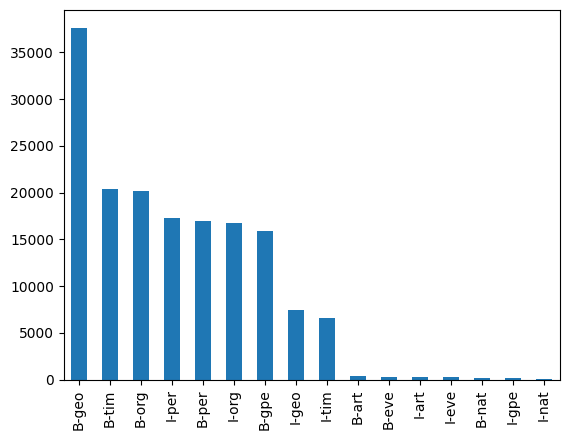

In [ ]:
import matplotlib.pyplot as plt
pd.value_counts(dataset[dataset['Tag'] != 'O']['Tag']).plot(kind = 'bar');

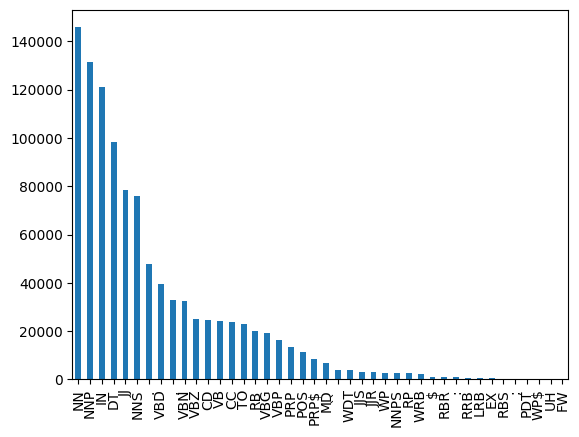

In [ ]:
pd.value_counts(dataset['POS']).plot(kind = 'bar');

In [9]:
WordList = dataset['Word'].tolist()
NERList = dataset['Tag'].tolist()
POSList = dataset['POS'].tolist()

Word2ix = {}
NER2ix = {}
POS2ix = {}

Word2ix['UNK'] = 0
Word2ix['PAD'] = 1

char2ix = {}
word2char = {}

for word, POS, NER in zip(WordList, POSList, NERList):
    if word not in Word2ix:
        Word2ix[word] = len(Word2ix)
    if POS not in POS2ix:
        POS2ix[POS] = len(POS2ix)
    if NER not in NER2ix:
        NER2ix[NER] = len(NER2ix)
    listchar = []
    for char in word:
        if char not in char2ix:
            char2ix[char] = len(char2ix)
        listchar.append(char2ix[char])
    word2char[word] = listchar

dataset['Wordix'] = dataset['Word'].map(Word2ix)
dataset['Tagix'] = dataset['Tag'].map(NER2ix)
dataset['POSix'] = dataset['POS'].map(POS2ix)
dataset['Char'] = dataset['Word'].map(word2char)
dataset = dataset.fillna(method='ffill', axis=0)
dataset.head()

,Sentence #,Word,POS,Tag,Wordix,Tagix,POSix,Char
0,Sentence: 1,Thousands,NNS,O,2,0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 4]"
1,Sentence: 1,of,IN,O,3,0,1,"[2, 8]"
2,Sentence: 1,demonstrators,NNS,O,4,0,0,"[7, 9, 10, 2, 6, 4, 11, 12, 5, 11, 2, 12, 4]"
3,Sentence: 1,have,VBP,O,5,0,2,"[1, 5, 13, 9]"
4,Sentence: 1,marched,VBN,O,6,0,3,"[10, 5, 12, 14, 1, 9, 7]"


In [10]:
data = dataset.groupby(
    ['Sentence #'], as_index=False
)['Word', 'POS', 'Tag', 'Wordix', 'Tagix', 'POSix', 'Char'].agg(lambda x: list(x));

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
data.head()

,Sentence #,Word,POS,Tag,Wordix,Tagix,POSix,Char
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 2, 3, 1, 4, 5, 6, 7, 8, 1, 4, 9, 6, ...","[[0, 1, 2, 3, 4, 5, 6, 7, 4], [2, 8], [7, 9, 1..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[126, 127, 128, 129, 130, 9, 131, 132, 9, 133,...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[10, 0, 2, 16, 2, 5, 6, 8, 5, 10, 10, 0, 1, 7,...","[[20, 12, 5, 6, 19, 5, 6], [2, 8, 8, 19, 14, 1..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[944, 945, 365, 946, 346, 947, 13, 11, 948, 25...","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, ...","[8, 0, 4, 12, 10, 0, 1, 7, 4, 10, 8, 21, 22, 1...","[[34, 9, 22, 19, 14, 2, 17, 11, 9, 12], [15, 3..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[44, 848, 135, 47, 4647, 4648, 4649, 33, 1880,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[16, 12, 1, 7, 8, 10, 8, 1, 8, 0, 11]","[[0, 1, 9, 24], [22, 9, 8, 11], [5, 8, 11, 9, ..."
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[156, 838, 1190, 7565, 9400, 174, 352, 95, 151...","[1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0,...","[4, 8, 8, 4, 4, 12, 4, 21, 4, 21, 10, 9, 10, 1...","[[51, 25, 31, 25], [12, 9, 22, 19, 9, 8], [14,..."


### 1. Train, test, dev split

In [11]:
from sklearn.model_selection import train_test_split
traindf, testdf = train_test_split(data, test_size=0.2, shuffle=True, random_state=36)
devdf, testdf = train_test_split(testdf, test_size=0.5, shuffle=True, random_state=36)

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def paddingSequence(data):
    wordToken = data['Wordix'].tolist()
    tagToken = data['Tagix'].tolist()
    posToken = data['POSix'].tolist()
    charToken = data['Char'].tolist()

    maxlen = max([len(w) for w in wordToken])
    wordToken = pad_sequences(wordToken, maxlen=maxlen, dtype='int32', padding='post', value=Word2ix['PAD'])
    tagToken = pad_sequences(tagToken, maxlen=maxlen, dtype='int32', padding='post', value=NER2ix['O'])
    #posToken = pad_sequences(posToken, maxlen=maxlen, dtype='int32', padding='post', value=POS2ix[''])
    #maxlenchar =  
    return wordToken, tagToken
    

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader
trainingData = TensorDataset(torch.tensor(paddingSequence(traindf)[0]), torch.tensor(paddingSequence(traindf)[1]))
testingData = TensorDataset(torch.tensor(paddingSequence(testdf)[0]), torch.tensor(paddingSequence(testdf)[1]))
validData = TensorDataset(torch.tensor(paddingSequence(devdf)[0]), torch.tensor(paddingSequence(devdf)[1]))

trainingData = DataLoader(trainingData, shuffle=True, batch_size=16)

In [14]:
ValidatingData = []
ValidatingTag = []
for index, data in enumerate(validData):
    ValidatingData.append(data[0])
    ValidatingTag.append(data[1])
ValidatingData = torch.stack(ValidatingData)
ValidatingTag = torch.stack(ValidatingTag)

### 2. Build Model

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1);

In [16]:
def oneHot(data):
    l = len(NER2ix)
    oh = torch.zeros((data.shape[0] * data.shape[1], l))
    for _, index in enumerate(data.flatten()):
        oh[_][index] = 1
    return oh

In [17]:
EMBEDDING_DIM = 200
HIDDEN_DIM = 150
BATCHSIZE = 16

In [18]:
class LSTMTagger(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, (h0, c0) = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out.view(-1, HIDDEN_DIM))
        tag_scores = F.softmax(tag_space, dim=1)
        return tag_scores

In [35]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(Word2ix), len(NER2ix))
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

with torch.no_grad():
    inputs = testingData[0][0]
    tag_scores = model(inputs)

Loss = []
ValLoss = []
for epoch in range(3): 
    l = 0
    print(f"epoch {epoch+1}: ")
    for index, (sentence, tags) in enumerate(trainingData):
        print(index, end = " ")
        model.zero_grad()

        tag_scores = model(sentence)
        tags = oneHot(tags)
        
        loss = loss_function(tag_scores, tags)
        loss.backward()
        optimizer.step()

        l += loss.item()
        if index == 2000:
            Loss.append(l/2000)
            break
    print('\n')
    valLoss = loss_function(model(ValidatingData), oneHot(ValidatingTag))
    ValLoss.append(valLoss.item())

epoch 1: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 

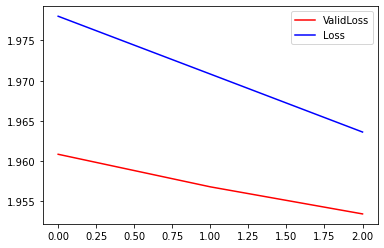

In [38]:
import matplotlib.pyplot as plt
plt.plot(ValLoss, c ='Red', label = 'ValidLoss')
plt.plot(Loss, c = 'Blue', label = 'Loss')
plt.legend(loc = 'best');

In [57]:
def checkAccuracy(testdata):
  true = 0
  len = 0
  for data in testdata:
    predict = torch.argmax(model(data[0]), dim = 1)
    labels = data[1]
    true += torch.sum(predict == labels).item()
    len += data[0].shape[0]
  return true/len

acc = checkAccuracy(testingData)

In [58]:
print(acc)

0.9595562439599137
